## 10) 문서 벡터를 이용한 추천 시스템(Recommendation System using Doc2Vec)

여러분이 어떤 다수의 문장 또는 문서를 가지고 있다고 해보자. 그리고 이 문서들을 서로 얼마나 유사한지 비교하고 싶다. 만약, 각 문서들을 고정된 길이의 벡터로 변환한다면 벡터 간 비교로 문서들을 서로 비교할 수 있을 것이다. 각 문서를 **문서 벡터로 변환하는 방법**은 이미 구현된 패키지인 Doc2Vec이나 Sent2Vec 등을 사용하여 훈련하는 방법이 존재하지만, 가장 간단한 방법은 **문서에 존재하는 단어 벡터들의 평균을 구하는 것**이다. 이번 챕터에서는 문서 내 각 단어들을 Word2Vec을 통해 단어 벡터로 변환하고, 이들의 평균으로 문서 벡터를 구하여 선호하는 도서와 유사한 도서를 찾아주는 도서 추천 시스템을 만들어보겠다.



### 1.데이터 로드

이번 챕터에서 사용할 데이터는 책의 이미지와 책의 줄거리를 크롤링한 데이터로 아래의 링크에서 다운로드할 수 있다.

데이터 다운로드 링크 : https://drive.google.com/file/d/15Q7DZ7xrJsI2Hji-WbkU9j1mwnODBd5A/view?usp=sharing

우선 필요한 도구들을 임포트한다.



In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd /content/gdrive/My Drive/02. 데이터

/content/gdrive/My Drive/02. 데이터


In [3]:
ls

 _about.txt                  IWSLT16.TED.tst2011.en-cs.en.xml
'강우예측AI 데이터'/         kowiki-latest-pages-articles.xml.bz2
 best_model.h5               model.png
 database.sqlite             ner_dataset.csv
 data.csv                    pr_report.html
 eng_w2v                     ratings.txt
 eng_w2v_metadata.tsv        Reviews.csv
 eng_w2v_tensor.tsv          spam.csv
 fra-eng.zip                 train.txt
 fra.txt                    '폭격의 날개왕(통합).txt'
'폭격의 날개왕(통합).gdoc'   wikiextractor/
 hashes.txt


In [4]:
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
from PIL import Image
from io import BytesIO
from nltk.tokenize import RegexpTokenizer
import nltk
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity

데이터를 데이터프레임으로 로드하고, 전체 문서의 수를 출력해보자.



In [5]:
df = pd.read_csv('data.csv')
print('전체 문서의 수 :', len(df))

전체 문서의 수 : 2382


상위 5개의 행만 출력해보자.


In [6]:
df[:5]

,Unnamed: 0,Desc,Unnamed: 0.1,author,genre,image_link,rating,title
0,0,We know that power is shifting: From West to E...,0.0,Moisés Naím,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.63,The End of Power: From Boardrooms to Battlefie...
1,1,Following the success of The Accidental Billio...,1.0,Blake J. Harris,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.94,"Console Wars: Sega, Nintendo, and the Battle t..."
2,2,How to tap the power of social software and ne...,2.0,Chris Brogan,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.78,Trust Agents: Using the Web to Build Influence...
3,3,William J. Bernstein is an American financial ...,3.0,William J. Bernstein,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.20,The Four Pillars of Investing
4,4,Amazing book. And I joined Steve Jobs and many...,4.0,Akio Morita,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.05,Made in Japan: Akio Morita and Sony


불필요한 열들이 존재하는데, 여기서는 문서 벡터를 만들기 위한 대상인 줄거리에 해당하는 열인 'Desc 열'이 중요하다. 해당 열에 있는 데이터에 대해서 Word2Vec을 학습하기 위해서는 전처리와 토큰화 과정이 필요할 것이다. 해당 열에 대해서 전처리를 수행하고, 'cleaned'라는 열에 저장해보자.



In [8]:
import nltk
nltk.download('stopwords')

def _removeNonAscii(s):
    return "".join(i for i in s if ord(i) < 128)

def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words('english'))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
    text = tokenizer.tokenize(text)
    text = ' '.join(text)
    return text

df['cleaned'] = df['Desc'].apply(_removeNonAscii)
df['cleaned'] = df.cleaned.apply(make_lower_case)
df['cleaned'] = df.cleaned.apply(remove_stop_words)
df['cleaned'] = df.cleaned.apply(remove_punctuation)
df['cleaned'] = df.cleaned.apply(remove_html)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


상위 5개의 행만 출력해보자.


In [9]:
df['cleaned'][:5]

0    know power shifting west east north south pres...
1    following success accidental billionaires mone...
2    tap power social software networks build busin...
3    william j bernstein american financial theoris...
4    amazing book joined steve jobs many akio morit...
Name: cleaned, dtype: object

전처리 과정에서 빈 값이 생긴 행이 있을 수 있다. 빈 값이 생긴 행이 있다면, nan 값으로 변환한 후에 해당 행을 제거해준다.



In [10]:
df['cleaned'].replace('', np.nan, inplace = True)
df = df[df['cleaned'].notna()]
print('전체 문서의 수 :', len(df))

전체 문서의 수 : 2381


빈 값이 있었던 행이 1개 있었는지, 전체 문서의 수가 1개가 줄어들었다. 이제 토큰화를 수행하여 corpus라는 리스트에 저장한다. 해당 리스트 corpus를 통해 Word2Vec을 훈련할 것이다.


In [11]:
corpus = []
for words in df['cleaned']:
    corpus.append(words.split())

In [12]:
corpus

[['know',
  'power',
  'shifting',
  'west',
  'east',
  'north',
  'south',
  'presidential',
  'palaces',
  'public',
  'squares',
  'formidable',
  'corporate',
  'behemoths',
  'nimble',
  'startups',
  'and',
  'slowly',
  'surely',
  'men',
  'women',
  'power',
  'merely',
  'shifting',
  'dispersing',
  'also',
  'decaying',
  'power',
  'today',
  'constrained',
  'risk',
  'losing',
  'ever',
  'before',
  'end',
  'power',
  'award',
  'winning',
  'columnist',
  'former',
  'foreign',
  'policy',
  'editor',
  'moiss',
  'nam',
  'illuminates',
  'struggle',
  'once',
  'dominant',
  'megaplayers',
  'new',
  'micropowers',
  'challenging',
  'every',
  'field',
  'human',
  'endeavor',
  'drawing',
  'provocative',
  'original',
  'research',
  'nam',
  'shows',
  'antiestablishment',
  'drive',
  'micropowers',
  'topple',
  'tyrants',
  'dislodge',
  'monopolies',
  'open',
  'remarkable',
  'new',
  'opportunities',
  'also',
  'lead',
  'chaos',
  'paralysis',
  'nam',

### 2.사전 훈련된 워드 임베딩 사용하기

Word2Vec을 처음부터 학습할 수도 있겠지만, 데이터가 충분하지 않은 상황에서 사전 훈련된 워드 임베딩을 단어 벡터의 초기값으로 사용하여 성능을 높일 수 있다. 여기서는 사전 훈련된 Word2Vec을 다운받아서 이를 초기 단어 벡터값으로 사용하겠다.



In [13]:
urllib.request.urlretrieve("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz", \
                           filename="GoogleNews-vectors-negative300.bin.gz")


('GoogleNews-vectors-negative300.bin.gz',
 <http.client.HTTPMessage at 0x7f3ca73ef4d0>)

In [14]:
ls

 _about.txt                              hashes.txt
'강우예측AI 데이터'/                     IWSLT16.TED.tst2011.en-cs.en.xml
 best_model.h5                           kowiki-latest-pages-articles.xml.bz2
 database.sqlite                         model.png
 data.csv                                ner_dataset.csv
 eng_w2v                                 pr_report.html
 eng_w2v_metadata.tsv                    ratings.txt
 eng_w2v_tensor.tsv                      Reviews.csv
 fra-eng.zip                             spam.csv
 fra.txt                                 train.txt
'폭격의 날개왕(통합).gdoc'              '폭격의 날개왕(통합).txt'
 GoogleNews-vectors-negative300.bin.gz   wikiextractor/


In [15]:
word2vec_model = Word2Vec(size = 300, window = 5, min_count = 2, workers = -1)
word2vec_model.build_vocab(corpus)
word2vec_model.intersect_word2vec_format('GoogleNews-vectors-negative300.bin.gz',
                                         lockf = 1.0, binary = True)
word2vec_model.train(corpus, total_examples = word2vec_model.corpus_count,
                     epochs = 15)

(0, 0)

### 3.단어 벡터의 평균 구하기

이제 각 문서에 존재하는 단어들의 벡터값의 평균을 구하여 해당 문서의 벡터값을 연산해보자.



In [16]:
def vectors(document_list):
    document_embedding_list = []

    # 각 문서에 대해서
    for line in document_list:
        doc2vec = None
        count = 0
        for word in line.split():
            if word in word2vec_model.wv.vocab:
                count += 1
                # 해당 문서에 있는 모든 단어들의 벡터값을 더한다.
                if doc2vec is None:
                    doc2vec = word2vec_model[word]
                else:
                    doc2vec = doc2vec + word2vec_model[word]
        
        if doc2vec is not None:
            # 단어 벡터를 모두 더한 벡터의 값을 문서 길이로 나눠준다.
            doc2vec = doc2vec / count
            document_embedding_list.append(doc2vec)

    # 각 문서에 대한 문서 벡터 리스트를 리턴
    return document_embedding_list
    

In [17]:
document_embedding_list = vectors(df['cleaned'])
print('문서 벡터의 수 :', len(document_embedding_list))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


문서 벡터의 수 : 2381


### 4.추천 시스템 구현하기

각 문서 벡터 간의 코사인 유사도를 구한다.


In [18]:
cosine_similarities = cosine_similarity(document_embedding_list, document_embedding_list)
print('코사인 유사도 메트릭스의 크기 :', cosine_similarities.shape)

코사인 유사도 메트릭스의 크기 : (2381, 2381)


이제 선택한 책에 대해서 코사인 유사도를 이용하여, 가장 줄거리가 유사한 5개의 책을 찾아내는 함수를 만든다.



In [19]:
def recommendations(title):
    books = df[['title', 'image_link']]

    # 책의 제목을 입력하면 해당 제목의 인덱스를 리턴받아 idx에 저장.
    indices = pd.Series(df.index, index = df['title']).drop_duplicates()
    idx = indices[title]

    # 입력된 책과 줄거리(document embedding)가 유사한 책 5개 선정.
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:6]

    # 가장 유사한 책 5권의 인덱스
    book_indices = [i[0] for i in sim_scores]

    # 전체 데이터프레임에서 해당 인덱스의 행만 추출. 5개의 행을 가진다.
    recommend = books.iloc[book_indices].reset_index(drop = True)

    fig = plt.figure(figsize = (20, 30))

    # 데이터프레임으로부터 순차적으로 이미지를 출력
    for index, row in recommend.iterrows():
        response = requests.get(row['image_link'])
        img = Image.open(BytesIO(response.content))
        fig.add_subplot(1, 5, index + 1)
        plt.imshow(img)
        plt.title(row['title'])

이제 좋아하는 책 제목을 입력으로 넣으면 해당 책 줄거리 벡터(문서 벡터)와 유사한 문서 벡터값을 가진 책들을 추천해준다. 여기서는 책 제목과 표지를 출력하도록 하였다.



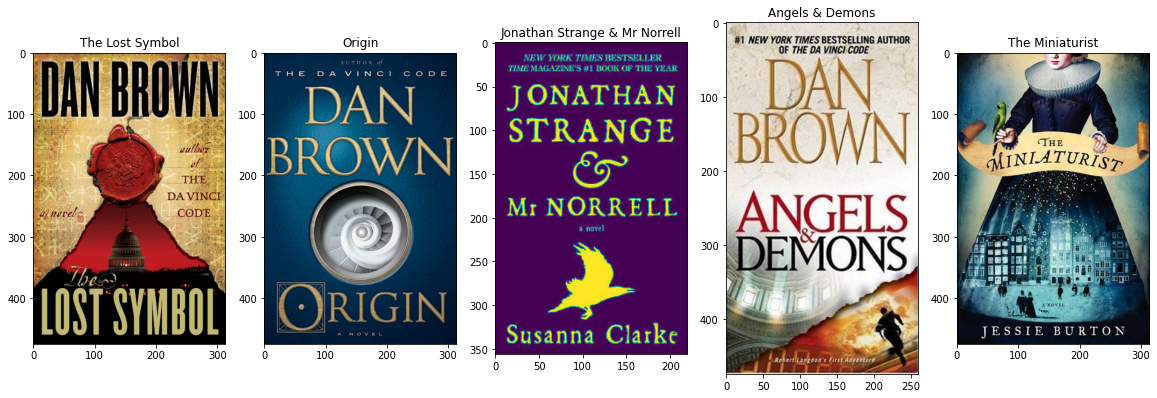

In [20]:
recommendations("The Da Vinci Code")

다빈치 코드는 작가 댄 브라운의 작품이다. 추천되는 작품들 또한 5개 중 3개가 댄 브라운의 작품들이 추천됨을 확인할 수 있다. 이번에는 아가사 크리스티의 애크로이드 살인사건과 유사한 도서를 추천받아 보자.


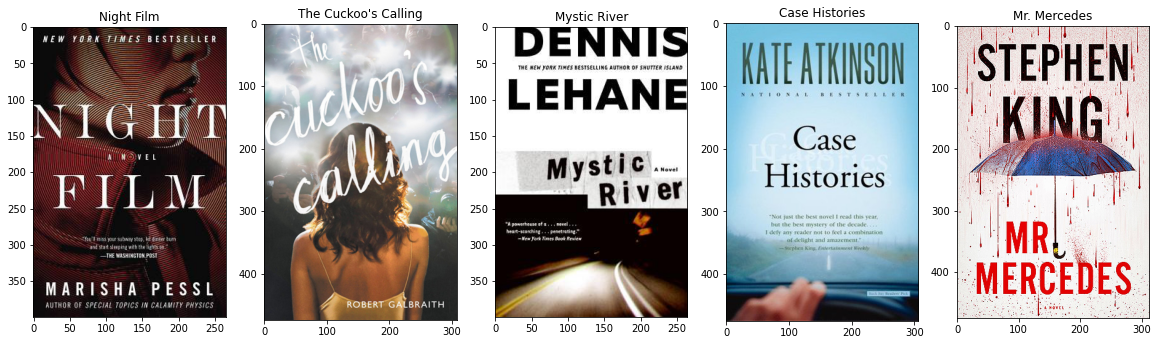

In [21]:
recommendations("The Murder of Roger Ackroyd")

애크로이드 살인사건은 미스터리 스릴러 소설인데, 이와 유사한 소설들이 추천되는 것을 확인할 수 있다.


http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/